# An analysis of the State of the Union speeches - Part 4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
import shelve
sns.set_style('whitegrid')
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Again, load data we need from previous parts without redoing that work.

## Distance between speeches

### By President

Let's first compute a few useful things we'll need later, like the unique set of all presidents and their initials (for plot labeling).

Now, make a dataframe that will contain the word counts aggregated by president:

In [2]:
# YOUR CODE HERE
wmat = pd.read_hdf('results/df3.h5', 'wmat')
addresses = pd.read_hdf('results/df1.h5', 'addresses')
#wmat.names=pd.DataFrame(data=wmat,columns=addresses['president'])
wmat.columns=addresses['president']
key1=list(Counter(addresses['president']).keys())
pres_mat=wmat.groupby(wmat.columns,axis=1).sum()                                                                                                                                                                                       
pres_mat.columns=key1
pres_mat.head()

,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James Polk,...,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George H.W. Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump
'',3,6,4,8,4,1,1,1,5,11,...,4,8,0,8,1,4,7,4,6,1
'd,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0,1,0
'm,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
's,4,5,3,8,4,4,3,1,9,10,...,1,8,2,8,2,4,8,4,8,0
",1892",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And `pmn` is a normalized version that turns counts into probability distributions:

In [3]:
value=pres_mat.iloc[:,:].values
value=value/value.sum(0,keepdims=True)
pmn=pd.DataFrame(np.array(value),columns=key1)
pmn.head()

,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James Polk,...,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George H.W. Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump
0,0.000551,0.000497,0.000616,0.000748,0.000510,0.000115,0.000216,0.00082,0.000441,0.001004,...,0.000691,0.00043,0.000000,0.000708,0.000418,0.000482,0.000665,0.000426,0.000836,0.000759
1,0.000000,0.000000,0.000000,0.000561,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000665,0.000000,0.000139,0.000000
2,0.000000,0.000000,0.000000,0.000748,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000475,0.000000,0.000000,0.000000
3,0.000735,0.000414,0.000462,0.000748,0.000510,0.000460,0.000649,0.00082,0.000794,0.000913,...,0.000173,0.00043,0.000364,0.000708,0.000836,0.000482,0.000760,0.000426,0.001115,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000127,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Sanity check: all columns should sum to 1.

In [4]:
pmn.sum()

  George Washington        1.0
  John Adams               1.0
  Thomas Jefferson         1.0
  James Madison            1.0
  James Monroe             1.0
  John Quincy Adams        1.0
  Andrew Jackson           1.0
  Martin van Buren         1.0
  John Tyler               1.0
  James Polk               1.0
  Zachary Taylor           1.0
  Millard Fillmore         1.0
  Franklin Pierce          1.0
  James Buchanan           1.0
  Abraham Lincoln          1.0
  Andrew Johnson           1.0
  Ulysses S. Grant         1.0
  Rutherford B. Hayes      1.0
  Chester A. Arthur        1.0
  Grover Cleveland         1.0
  Benjamin Harrison        1.0
  William McKinley         1.0
  Theodore Roosevelt       1.0
  William H. Taft          1.0
  Woodrow Wilson           1.0
  Warren Harding           1.0
  Calvin Coolidge          1.0
  Herbert Hoover           1.0
  Franklin D. Roosevelt    1.0
  Harry S. Truman          1.0
  Dwight D. Eisenhower     1.0
  John F. Kennedy          1.0
  Lyndon

Make a numpy array version to use with Scikit-Learn:

In [5]:
# YOUR CODE HERE
pmm=np.array(pmn)
pmm.shape

(18797, 42)

You can use the JSdiv function below as-is, it already works.

In [6]:
from scipy.stats import entropy

def JSdiv(p, q):
    """Jensen-Shannon divergence.
    
    Compute the J-S divergence between two discrete probability distributions.
    
    Parameters
    ----------
    
    p, q : array
        Both p and q should be one-dimensional arrays that can be interpreted as discrete
        probability distributions (i.e. sum(p) == 1; this condition is not checked).
        
    Returns
    -------
    float
        The J-S divergence, computed using the scipy entropy function (with base 2) for
        the Kullback-Leibler divergence.
    """
    m = (p + q) / 2
    return (entropy(p, m, base=2.0) + entropy(q, m, base=2.0)) / 2

This is a "naive" plot where we use the $L^2$ distance to build the embedding.

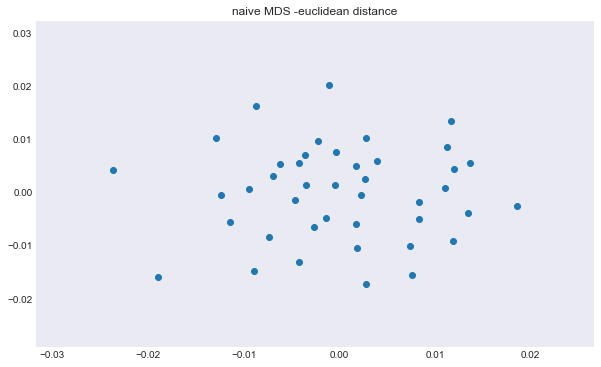

In [7]:
from sklearn.manifold import MDS
import random
random.seed()
ee=np.array(pmm.T)
mds=MDS()
lower_naive=mds.fit_transform(ee)
lower_df=pd.DataFrame({'x_naive':lower_naive[:,0],'y_naive':lower_naive[:,1],'President':key1})
plt.scatter(lower_df['x_naive'],lower_df['y_naive'])
plt.title('naive MDS -euclidean distance')
#plt.annotate(*key1)
# A simple MDS embedding plot:


*** This graph is not good enough, we need to put add in legends and other information to make it look care and straightforward ***	

This will be more informative if we make a little utility function for the plots, that carries a legend, annotates each point with the president's initials, and colors them all:

In [8]:
'''def plot_embedding(data, title='MDS Embedding', savepath=None, palette='viridis', 
                  # size=7, annotate='initials'):
    """Plot an MDS embedding dataframe for all presidents.
    
    Uses Seaborn's `lmplot` to create an x-y scatterplot of the data, encoding the 
    value of the `President` field into the hue (which can be mapped to any desired
    color palette).
    
    Parameters
    ----------
    data : DataFrame
        A DataFrame that must contain 3 columns labeled 'x', 'y' and 'President'.
        
    title : optional, string
        Title for the plot
        
    savepath : optional, string
        If given, a path to save the figure into using matplotlib's `savefig`.
        
    palette : optional, string
        The name of a valid Seaborn palette for coloring the points.
    
    size : optional, float
        Size of the plot in inches (single number, square plot)
        
    annotate: optional, 'initials', 'name' or False
        If 'initials', annotate each point with the intials of each president,
        if 'name', use their last name, and if False, do not annotate at all.
        
    Returns
    -------
    FacetGrid
        The Seaborn FacetGrid object used to create the plot.
    """

    # YOUR CODE HERE
    #f=sns.lmplot(x='x',y='y',data=data,fit_reg=False, hue='President',palette=palette)
    #f.figsize=(size)
    #f.savefig(savepath)
    #return '''

'def plot_embedding(data, title=\'MDS Embedding\', savepath=None, palette=\'viridis\', \n                  # size=7, annotate=\'initials\'):\n    """Plot an MDS embedding dataframe for all presidents.\n    \n    Uses Seaborn\'s `lmplot` to create an x-y scatterplot of the data, encoding the \n    value of the `President` field into the hue (which can be mapped to any desired\n    color palette).\n    \n    Parameters\n    ----------\n    data : DataFrame\n        A DataFrame that must contain 3 columns labeled \'x\', \'y\' and \'President\'.\n        \n    title : optional, string\n        Title for the plot\n        \n    savepath : optional, string\n        If given, a path to save the figure into using matplotlib\'s `savefig`.\n        \n    palette : optional, string\n        The name of a valid Seaborn palette for coloring the points.\n    \n    size : optional, float\n        Size of the plot in inches (single number, square plot)\n        \n    annotate: optional, \'initials\', 

In [9]:
lower_df.columns=['x','y','President']
embed_peu=lower_df
#plot_embedding(embed_peu, 'Naive MDS - euclidean distance', 'fig/mds_naive.png', annotate='name');

Now we use a distance metric defined on probability mass functions, the Jensen-Shannon Metric.

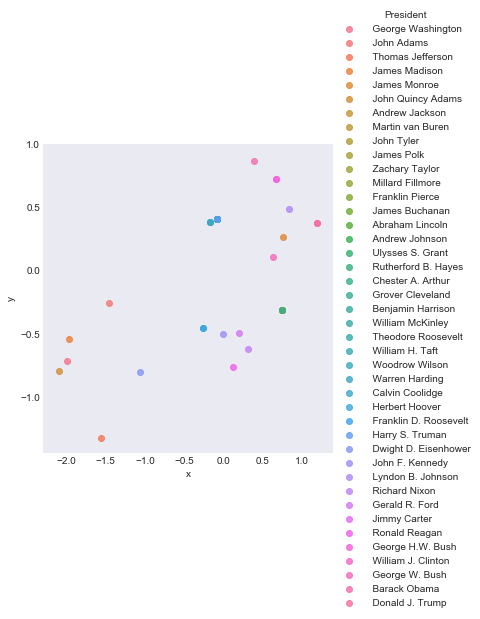

In [10]:
m,n=pmm.T.shape
dist=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        dist[i,j]=JSdiv(pmm[i,:],pmm[j,:])
mds1=MDS(dissimilarity="precomputed")
lower=mds1.fit_transform(dist)
edf2=pd.DataFrame({'x':lower[:,0] ,'y':lower[:,1],'President':key1})
sns.lmplot(x='x',y='y',data=edf2,fit_reg=False, hue='President')#,scatter_kws=({plt.title:'a'}))
#plot_embedding(edf2, 'MDS - Jensen-Shannon Distance', 'fig/mds_jsdiv.png', annotate='name');

*** The purpose of multidimensional scaling (MDS) is to provide a visual representation of the pattern of proximities among a set of objects, in this case, the set is each Presidents. One of the things to look for in interpreting this MDS graph is the cluster. Clusters are groups of items that are closer to each other than to other items. In this graph, there seems to be two group of clusters of points. This means that within these two clusters, the Presidents speeches has similar characteristic ***

### By Speech
First we normalize the term-document matrix

We make a similar naive plot embedding using the $L^2$ distance.

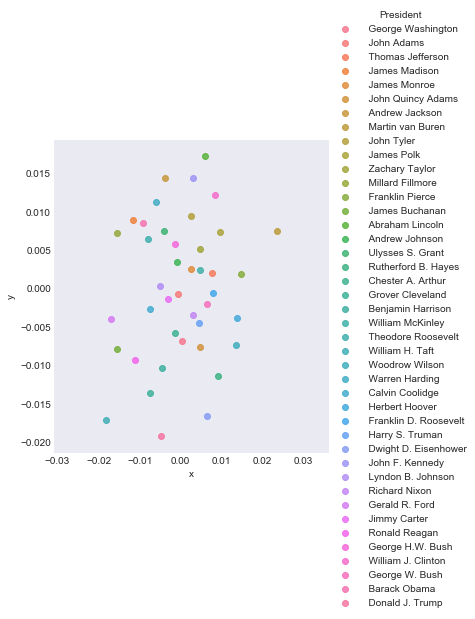

In [11]:
pres_mat_n=pres_mat.iloc[:,:].values
pres_mat_n=pres_mat_n/pres_mat_n.sum(0,keepdims=True)

lower_naive=mds.fit_transform(pres_mat_n.T)
embed_df=pd.DataFrame({'x':lower_naive[:,0],'y':lower_naive[:,1],'President':list(Counter(addresses['president']).keys())})

f=sns.lmplot(x='x',y='y',data=embed_df,fit_reg=False, hue='President')
f.savefig('fig/mds_naive_all.png')
#plot_embedding(embed_df, 'Naive MDS - euclidean distance, all speeches',
               #'fig/mds_naive_all.png', size=10);

Now with the Jensen-Shannon metric

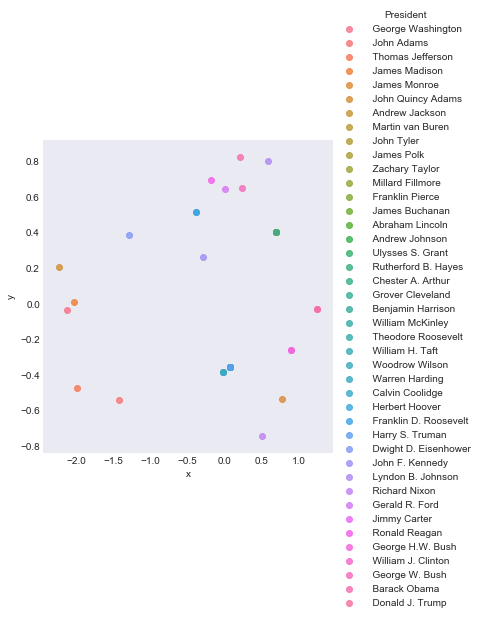

In [12]:
m,n=pres_mat_n.T.shape
dist=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        dist[i,j]=JSdiv(pres_mat_n[i,:],pres_mat_n[j,:])
mds1=MDS(dissimilarity="precomputed")
lower=mds1.fit_transform(dist)
embed_df2=pd.DataFrame({'x':lower[:,0] ,'y':lower[:,1],'President':key1})
f1=sns.lmplot(x='x',y='y',data=embed_df2,fit_reg=False, hue='President')

#plot_embedding(embed_df2, 'Naive MDS - Jensen-Shannon distance, all speeches', 
               #'fig/mds_jdsiv_all.png', size=10);
f1.savefig('fig/mds_jdsiv_all.png')

Store some final results. For native numpy arrays, we can use the convenient numpy `npz` container format, which behaves in practice similar to the Pandas HDF5 store and the Python Shelves:

In [13]:
np.savez('results/npa4.npz', pmm=pmm)